<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com) for PyCon 2014. Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_pycon2014/).</i></small>

# Validation and Model Selection

This section builds on the previous discussions, and goes into more depth on how to evaluate and improve a the training of a supervised Classification or Regression model.

By the end of this section, you will:

- Know several metrics by which models can be evaluated
- Know the difference between *bias* and *variance*, and why there is a tradeoff
- Know how to use *(cross) validation curves* to evaluate & improve your model
- Know how to use *learning curves* to further evaluate & improve your model

Recall our previous discussion of the importance of splitting data into a *training set* and a *testing set*: we'll be extending that here.

In [124]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

## Exploring Validation Metrics

How can you evaluate the performance of a model?

The simplest way might be to count the number of matches and mis-matches. But this is not always sufficient.  For example, imagine you have a situation where you'd like to identify a rare class of event from within a large number of background sources (in my field, an example of this is finding variable stars from the background of non-varying stars).  This "number of matches" metric can break down:

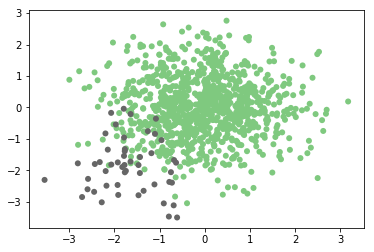

In [125]:
# Generate an un-balanced 2D dataset
np.random.seed(0)
X = np.vstack([np.random.normal(0, 1, (950, 2)),
               np.random.normal(-1.8, 0.8, (50, 2))])
y = np.hstack([np.zeros(950), np.ones(50)])

plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='none',
            cmap=plt.cm.Accent);

### Quick Exercise #1

Use a *Support Vector Machine*, and see how well the model can classify this data.  You can use what we did above as a template:

In [126]:
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split

# First instantiate the "Support Vector Classifier" (SVC) model
svc = SVC()

# Next split the data (X and y) into a training and test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

# fit the model to the training data
svc.fit(Xtrain, ytrain)

# compute y_pred, the predicted labels of the test data
ypred = svc.predict(Xtest)

# Now that this is finished, we'll compute the classification rate
print ("accuracy:", np.sum(ytest == ypred) * 1. / len(ytest))

accuracy: 0.964


Did you do well?  Would you say that this is a good classification scheme for the problem?

In [127]:
# %load solutions/06-1_svm_class.py

### The Problem with Simple Validation

The problem here is that we might not care how well we can classify the **background**, but might instead be concerned with successfully pulling-out an uncontaminated set of **foreground** sources.  We can get at this by computing statistics such as the **precision**, the **recall**, and the **f1 score**:

In [128]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
clf = SVC().fit(X_train, y_train)
y_pred = clf.predict(X_test)

print ("accuracy:", metrics.accuracy_score(y_test, y_pred))
print ("precision:", metrics.precision_score(y_test, y_pred))
print ("recall:", metrics.recall_score(y_test, y_pred))
print ("f1 score:", metrics.f1_score(y_test, y_pred))

accuracy: 0.968
precision: 0.8333333333333334
recall: 0.625
f1 score: 0.7142857142857143


#### What do these mean?

These are ways of taking into account not just the classification results, but the results **relative to the true category**.

$$ {\rm accuracy} \equiv \frac{\rm correct~labels}{\rm total~samples} $$

$$ {\rm precision} \equiv \frac{\rm true~positives}{\rm true~positives + false~positives} $$

$$ {\rm recall} \equiv \frac{\rm true~positives}{\rm true~positives + false~negatives} $$

$$ F_1 \equiv 2 \frac{\rm precision \cdot recall}{\rm precision + recall} $$

The **accuracy**, **precision**, **recall**, and **f1-score** all range from 0 to 1, with 1 being optimal.
Here we've used the following definitions:

- *True Positives* are those which are labeled ``1`` which are actually ``1``
- *False Positives* are those which are labeled ``1`` which are actually ``0``
- *True Negatives* are those which are labeled ``0`` which are actually ``0``
- *False Negatives* are those which are labeled ``0`` which are actually ``1``


We can quickly compute a summary of these statistics using scikit-learn's provided convenience function:

In [129]:
print (metrics.classification_report(y_test, y_pred, target_names=['background', 'foreground']))

             precision    recall  f1-score   support

 background       0.97      0.99      0.98       234
 foreground       0.83      0.62      0.71        16

avg / total       0.97      0.97      0.97       250



This tells us that, though the overall correct classification rate is 97%, we only correctly identify 67% of the desired samples, and those that we label as positives are only 83% correct!  This is why you should make sure to carefully choose your metric when validating a model.

### Quick Exercise #2

Compare the *K Neighbors Classifier*, the *Gaussian Naive Bayes Classifier*, and the *Support Vector Machine Classifier* on this toy dataset, using their default parameters.  Which is most accurate?  Which is most precise?  Which has the best recall?

Imagine that you are a medical doctor, and here the features are biometric measurements, and the labels are

- 0 = no disease
- 1 = potential infection

For your patients, which classifier might you choose? (That is, would you be more concerned with accuracy, precision, or recall?)

In [130]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

for clf in [KNeighborsClassifier(), GaussianNB(), SVC()]:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(metrics.classification_report(y_test, y_pred, target_names=['no_disease', 'possible_infection']))
#    print(metrics.confusion_matrix(y_test, y_pred))

                    precision    recall  f1-score   support

        no_disease       0.97      0.98      0.98       234
possible_infection       0.71      0.62      0.67        16

       avg / total       0.96      0.96      0.96       250

                    precision    recall  f1-score   support

        no_disease       0.98      0.99      0.99       234
possible_infection       0.86      0.75      0.80        16

       avg / total       0.97      0.98      0.98       250

                    precision    recall  f1-score   support

        no_disease       0.97      0.99      0.98       234
possible_infection       0.83      0.62      0.71        16

       avg / total       0.97      0.97      0.97       250



In [131]:
# %load solutions/06-2_unbalanced.py

## Cross-Validation

Using the simple train/test split as above can be useful, but there is a disadvantage: **Your fit is ignoring a portion of your dataset**.  One way to address this is to use cross-validation.

The simplest cross-validation scheme involves running two trials, where you split the data into two parts, first training on one, then training on the other:

In [132]:
X1, X2, y1, y2 = train_test_split(X, y, test_size=0.5)
print (X1.shape)
print (X2.shape)

(500, 2)
(500, 2)


In [133]:
y2_pred = SVC().fit(X1, y1).predict(X2)
y1_pred = SVC().fit(X2, y2).predict(X1)

print (np.mean([metrics.precision_score(y1, y1_pred),
               metrics.precision_score(y2, y2_pred)]))

0.8284313725490196


This is known as **two-fold** cross-validation, and is a special case of *K*-fold cross validation.

Because it's such a common routine, scikit-learn has a K-fold cross-validation scheme built-in:

In [134]:
from sklearn.cross_validation import cross_val_score

# Let's do a 2-fold cross-validation of the SVC estimator
print (cross_val_score(SVC(), X, y, cv=2, scoring='precision'))

[0.73684211 0.875     ]


It's also possible to use ``sklearn.cross_validation.KFold`` and ``sklearn.cross_validation.StratifiedKFold`` directly, as well as other cross-validation models which you can find in the ``cross_validation`` module.

### Quick Exercise #3

The ``SVC`` classifier takes a parameter ``C`` whose default value is ``1``.  Using 5-fold cross-validation, make a plot of the precision as a function of ``C``, for the ``SVC`` estimator on this dataset.  For best results, use a logarithmic spacing of ``C`` between 0.01 and 100.

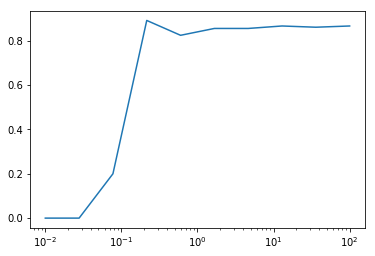

In [135]:
from sklearn.svm import SVC
cv_score = []
Cs = np.logspace(-2, 2, 10)
for c in Cs:
    cv_score.append(cross_val_score(SVC(C=c), X, y, cv=5, scoring='precision').mean())
    
plt.semilogx(Cs, cv_score)
plt.show()

In [136]:
# %load solutions/06-3_5fold_crossval.py


## Grid Search

This exercise you just completed is an example of a **grid search** for model evaluation.  Again, because this is such a common task, Scikit-learn has a grid search tool built-in, which is used as follows.  Note that ``GridSearchCV`` has a ``fit`` method: it is a meta-estimator: an estimator over estimators!

In [137]:
from sklearn.grid_search import GridSearchCV

clf = SVC()
Crange = np.logspace(-2, 2, 40)

grid = GridSearchCV(clf, param_grid={'C': Crange},
                    scoring='precision', cv=5)
grid.fit(X, y)

print ("best parameter choice:", grid.best_params_)

best parameter choice: {'C': 0.10608183551394483}


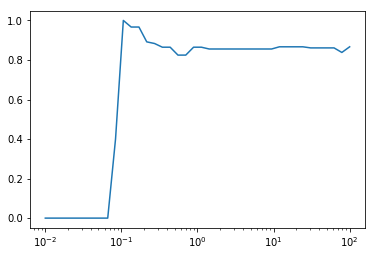

In [138]:
scores = [g[1] for g in grid.grid_scores_]
plt.semilogx(Crange, scores);

Grid search can come in very handy when you're tuning a model for a particular task.

### Quick Exercise #4

Use ``GridSearchCV`` with the nearest neighbors estimator (``sklearn.neighbors.KNeighborsClassifier``) to determine the optimal number of neighbors (``n_neighbors``) for classifying digits (use accuracy as your metric).

Best Params: {'n_neighbors': 2}


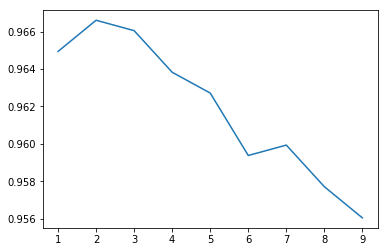

In [139]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_digits
digits = load_digits()
X, y = digits.data, digits.target
n_array = np.arange(1, 10)
params = {'n_neighbors':n_array}
# construct the K Neighbors classifier
knc = KNeighborsClassifier()

# Use GridSearchCV to find the best accuracy given choice of ``n_neighbors``
from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(knc, param_grid=params, cv=5, scoring='accuracy')
grid.fit(X, y)


# Plot the accuracy as a function of the number of neighbors.
# Does this change significantly if you use more/fewer folds?
scores = [g[1] for g in grid.grid_scores_]
print('Best Params: {}'.format(grid.best_params_))
plt.plot(n_array, scores)
plt.show()

In [140]:
# %load solutions/06-4_gridsearch.py

## Overfitting, Underfitting and Model Selection

Now that we've gone over the basics of metrics, validation, and cross-validation, it's time to go into even more depth regarding model selection.

The issues associated with validation and 
cross-validation are some of the most important
aspects of the practice of machine learning.  Selecting the optimal model
for your data is vital, and is a piece of the problem that is not often
appreciated by machine learning practitioners.

Of core importance is the following question:

**If our estimator is underperforming, how should we move forward?**

- Use simpler or more complicated model?
- Add more features to each observed data point?
- Add more training samples?

The answer is often counter-intuitive.  In particular, **Sometimes using a
more complicated model will give _worse_ results.**  Also, **Sometimes adding
training data will not improve your results.**  The ability to determine
what steps will improve your model is what separates the successful machine
learning practitioners from the unsuccessful.

## Illustration of the Bias-Variance Tradeoff

For this section, we'll work with a simple 1D regression problem.  This will help us to
easily visualize the data and the model, and the results generalize easily to  higher-dimensional
datasets.  We'll explore a simple **linear regression** problem.
This can be accomplished within scikit-learn with the `sklearn.linear_model` module.

We'll create a simple nonlinear function that we'd like to fit

In [141]:
def test_func(x, err=0.5):
    y = 10 - 1. / (x + 0.1)
    if err > 0:
        y = np.random.normal(y, err)
    return y

Now let's create a realization of this dataset:

In [142]:
def make_data(N=40, error=1.0, random_seed=1):
    # randomly sample the data
    np.random.seed(1)
    X = np.random.random(N)[:, np.newaxis]
    y = test_func(X.ravel(), error)
    
    return X, y

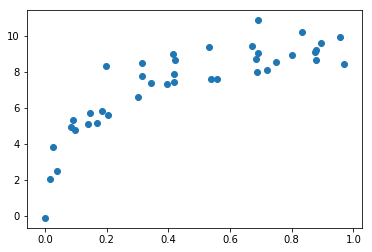

In [143]:
X, y = make_data(40, error=1)
plt.scatter(X.ravel(), y);

Now say we want to perform a regression on this data.  Let's use the built-in linear regression function to compute a fit:

mean squared error: 1.7851464506138046


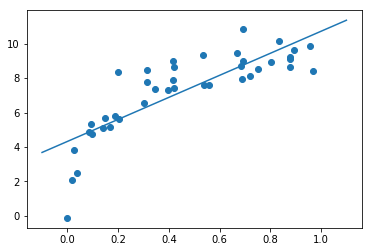

In [145]:
X_test = np.linspace(-0.1, 1.1, 500)[:, None]

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
print ("mean squared error:", metrics.mean_squared_error(model.predict(X), y))

We have fit a straight line to the data, but clearly this model is not a good choice.  We say that this model is **biased**, or that it **under-fits** the data.

Let's try to improve this by creating a more complicated model.  We can do this by adding degrees of freedom, and computing a polynomial regression over the inputs.  Let's make this easier by creating a quick PolynomialRegression estimator:

In [146]:
class PolynomialRegression(LinearRegression):
    """Simple Polynomial Regression to 1D data"""
    def __init__(self, degree=1, **kwargs):
        self.degree = degree
        LinearRegression.__init__(self, **kwargs)
        
    def fit(self, X, y):
        if X.shape[1] != 1:
            raise ValueError("Only 1D data valid here")
        Xp = X ** (1 + np.arange(self.degree))
        return LinearRegression.fit(self, Xp, y)
        
    def predict(self, X):
        Xp = X ** (1 + np.arange(self.degree))
        return LinearRegression.predict(self, Xp)

Now we'll use this to fit a quadratic curve to the data.

mean squared error: 0.9197171922424536


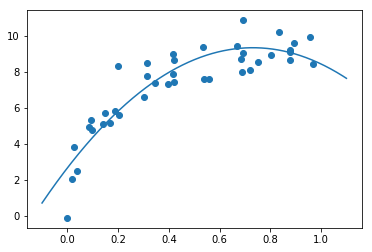

In [147]:
model = PolynomialRegression(degree=2)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
print ("mean squared error:", metrics.mean_squared_error(model.predict(X), y))

This reduces the mean squared error, and makes a much better fit.  What happens if we use an even higher-degree polynomial?

mean squared error: 0.37553105254442026


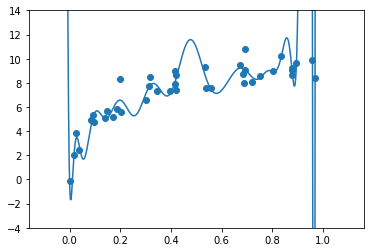

In [148]:
model = PolynomialRegression(degree=30)
model.fit(X, y)
y_test = model.predict(X_test)

plt.scatter(X.ravel(), y)
plt.plot(X_test.ravel(), y_test)
plt.ylim(-4, 14)
print ("mean squared error:", metrics.mean_squared_error(model.predict(X), y))

When we increase the degree to this extent, it's clear that the resulting fit is no longer reflecting the true underlying distribution, but is more sensitive to the noise in the training data. For this reason, we call it a **high-variance model**, and we say that it **over-fits** the data.

## Detecting over-fitting
Clearly, computing the error on the training data is not enough (we saw this previously).  But computing this *training error* can help us determine what's going on: in particular, comparing the training error and the validation error can give you an indication of how well your data is being fit.

Let's do this:

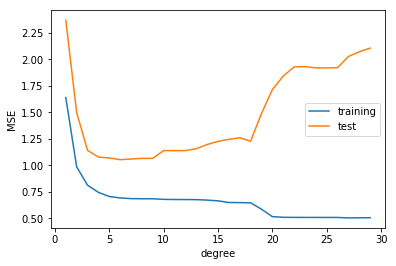

In [149]:
degrees = np.arange(1, 30)

X, y = make_data(100, error=1.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

training_error = []
test_error = []
mse = metrics.mean_squared_error

for d in degrees:
    model = PolynomialRegression(d).fit(X_train, y_train)
    training_error.append(mse(model.predict(X_train), y_train))
    test_error.append(mse(model.predict(X_test), y_test))
    
# note that the test error can also be computed via cross-validation
plt.plot(degrees, training_error, label='training')
plt.plot(degrees, test_error, label='test')
plt.legend()
plt.xlabel('degree')
plt.ylabel('MSE');

This is a typical bias/variance plot.

On the **Left Side** of the plot, we have a **high-bias** model, characterized by the training and test data showing equally bad performance.  This shows that the model is **under-fitting** the data, because it does equally poorly on both known and unknown values.

On the **Right Side** of the plot, we have a **high-variance model**, characterized by a divergence of the training and test data.  Here the model is **over-fitting** the data: in other words, the particular noise distribution of the input data has too much effect on the result.

The optimal model here will be around the point where the **test** error is minimized.

### Quick Exercise # 5

Let's appy this learning curve idea to a **Decision Tree** regression on this dataset. ``sklearn.tree.DecisionTree`` takes a number of hyper-parameters, but one that can really control the over-fitting, under-fitting is the ``max_depth`` parameter especially controls the tradeoff between bias and variance.

Generate a dataset like the one above, but containing 500 points, and use a Decision Tree regressor to explore the effect of the ``max_depth`` parameter on the bias/variance tradeoff.  What is the optimal value?

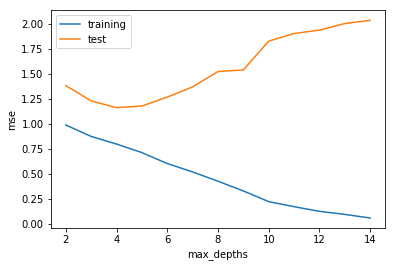

Optimal Value of max_depth = 4


In [155]:
from sklearn.tree import DecisionTreeRegressor

X, y = make_data(500, error=1.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
training_error=[]
test_error=[]
mse = metrics.mean_squared_error

depths=np.arange(2, 15)
for d in depths:
    dt = DecisionTreeRegressor(max_depth=d)
    dt.fit(X_train, y_train)
    training_error.append(mse(dt.predict(X_train), y_train))
    test_error.append(mse(dt.predict(X_test), y_test))
plt.plot(depths, training_error, label='training')
plt.plot(depths, test_error, label='test')
plt.legend()
plt.xlabel('max_depths')
plt.ylabel('mse')
plt.show()
print('Optimal Value of max_depth = 4')

In [154]:
# %load solutions/06-5_decisiontree.py

### Quick Exercise #6

One popular and effective way to address over-fitting is to use **Ensemble methods**.  ``sklearn.ensemble.RandomForestRegressor`` uses multiple randomized decision trees and averages their results.  The ensemble of estimators can often do better than any individual estimator for data that is over-fit.  Repeat the above experiment using the Random Forest regressor, with 10 trees.  What is the best ``max_depth`` for this model?  Does the accuracy improve?

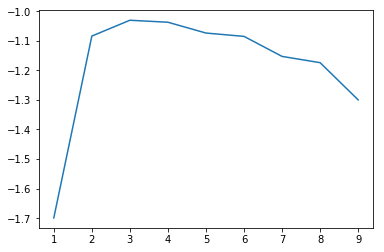

In [164]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=10)
depths = np.arange(1, 10)
grid = GridSearchCV(rf, param_grid={'max_depth':depths}, cv=5, scoring='mean_squared_error')
grid.fit(X, y)

score = [g[1] for g in grid.grid_scores_]
plt.plot(depths, score)
plt.show()

In [165]:
# %load solutions/06-6_randomforest.py

## Illustration of Learning Curves

The exact turning-point of the tradeoff between bias and variance is highly dependent on the number of training points used.  Here we'll illustrate the use of *learning curves*, which display this property.

The idea is to plot the mean-squared-error for the training and test set as a function of *Number of Training Points*

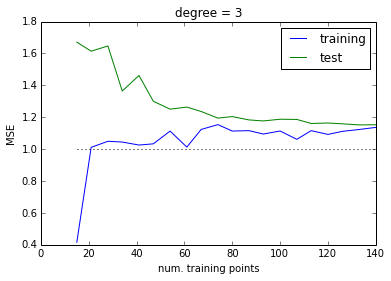

In [27]:
X, y = make_data(200, error=1.0)
degree = 3

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

N_range = np.linspace(15, X_train.shape[0], 20).astype(int)

def plot_learning_curve(degree=3):
    training_error = []
    test_error = []
    mse = metrics.mean_squared_error
    
    for N in N_range:
        XN = X_train[:N]
        yN = y_train[:N]
    
        model = PolynomialRegression(degree).fit(XN, yN)
        training_error.append(mse(model.predict(XN), yN))
        test_error.append(mse(model.predict(X_test), y_test))
      
    plt.plot(N_range, training_error, label='training')
    plt.plot(N_range, test_error, label='test')
    plt.plot(N_range, np.ones_like(N_range), ':k')
    plt.legend()
    plt.title('degree = {0}'.format(degree))
    plt.xlabel('num. training points')
    plt.ylabel('MSE')
    
plot_learning_curve(3)

This shows a typical learning curve: for very few training points, there is a large separation between the training and test error, which indicates **over-fitting**.  Given the same model, for a large number of training points, the training and testing errors converge, which indicates potential **under-fitting**.

It is easy to see that, in this plot, if you'd like to reduce the MSE down to the nominal value of 1.0 (which is the magnitude of the scatter we put in when constructing the data), then adding more samples will *Never* get you there.  For $d=3$, we've already converged.  What about for $d=1$?

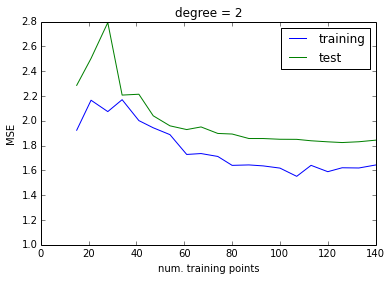

In [28]:
plot_learning_curve(2)

We see that it hasn't converged yet: you still might expect to decrease the test error by adding more points.

What about the other extreme?

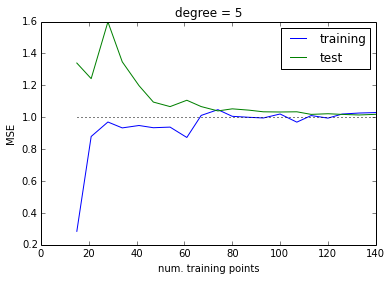

In [29]:
plot_learning_curve(5)

For $d=5$, it's converged, but to a better value than for $d=3$.

Thus you can **bring the two curves closer together** by adding more points, but you can **bring the convergence level down** only by adding complexity to the model.

This can be very useful, because it gives you a hint about how to improve upon results which are sub-par.  To make this more concrete, imagine an astronomy project in which the results are not robust enough.  You must think about whether to spend your valuable telescope time observing *more objects* to get a larger training set, or *more attributes of each object* in order to improve the model.  The answer to this question is important, and can be addressed using these metrics.

### Final Exercise

Let's return to our digits data.  Using what you've learned here, explore several classifiers and find the optimal classifier for this dataset.  What is the best **accuracy** you can attain on a 5-fold cross-validation over the data?  Are there indications that more training data would be helpful in improving this accuracy?

In [30]:
# As this final exercise is fairly open-ended, there is no solution provided!